# 1. Preparación de los datos

## Paso 1: Importación de librerías y carga de datos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report)

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

# Cargar datos limpios
df = pd.read_csv('TelecomX_Limpio.csv')
print(f"Dataset cargado: {df.shape}")
print(f"Columnas: {list(df.columns)}")

Dataset cargado: (7032, 22)
Columnas: ['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Charges.Monthly', 'Charges.Total', 'Cuentas_Diarias']


## Paso 2: Verificación y limpieza inicial

In [2]:
# Información básica del dataset
print("Información del dataset:")
print(df.info())

print("\nValores nulos:")
print(df.isnull().sum())

print("\nDistribución de Churn:")
churn_dist = df['Churn'].value_counts()
print(churn_dist)
print(f"Porcentaje de churn: {churn_dist[True]/len(df)*100:.1f}%")

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   Churn             7032 non-null   bool   
 2   gender            7032 non-null   object 
 3   SeniorCitizen     7032 non-null   bool   
 4   Partner           7032 non-null   bool   
 5   Dependents        7032 non-null   bool   
 6   tenure            7032 non-null   int64  
 7   PhoneService      7032 non-null   bool   
 8   MultipleLines     7032 non-null   bool   
 9   InternetService   7032 non-null   object 
 10  OnlineSecurity    7032 non-null   bool   
 11  OnlineBackup      7032 non-null   bool   
 12  DeviceProtection  7032 non-null   bool   
 13  TechSupport       7032 non-null   bool   
 14  StreamingTV       7032 non-null   bool   
 15  StreamingMovies   7032 non-null   bool   
 16  Contract         

## Paso 3: Preparación de variables

In [3]:
# Crear copia para transformaciones
df_ml = df.copy()

# Eliminar columnas irrelevantes
if 'customerID' in df_ml.columns:
    df_ml = df_ml.drop(['customerID'], axis=1)

# Identificar tipos de variables
numericas = df_ml.select_dtypes(include=['int64', 'float64']).columns.tolist()
booleanas = df_ml.select_dtypes(include=['bool']).columns.tolist()
categoricas = df_ml.select_dtypes(include=['object']).columns.tolist()

print(f"Variables numéricas ({len(numericas)}): {numericas}")
print(f"Variables booleanas ({len(booleanas)}): {booleanas}")
print(f"Variables categóricas ({len(categoricas)}): {categoricas}")

Variables numéricas (4): ['tenure', 'Charges.Monthly', 'Charges.Total', 'Cuentas_Diarias']
Variables booleanas (13): ['Churn', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling']
Variables categóricas (4): ['gender', 'InternetService', 'Contract', 'PaymentMethod']


## Paso 4: Encoding de variables categóricas

In [4]:
# Aplicar One-Hot Encoding a variables categóricas
if categoricas:
    df_encoded = pd.get_dummies(df_ml, columns=categoricas, drop_first=True)
else:
    df_encoded = df_ml.copy()

print(f"Shape después del encoding: {df_encoded.shape}")
print(f"Nuevas columnas creadas: {df_encoded.shape[1] - df_ml.shape[1]}")

Shape después del encoding: (7032, 25)
Nuevas columnas creadas: 4


## Paso 5: División de datos

In [5]:
# Separar características (X) y variable objetivo (y)
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Datos de entrenamiento: {X_train.shape}")
print(f"Datos de prueba: {X_test.shape}")
print(f"Distribución de churn en entrenamiento: {y_train.value_counts().values}")
print(f"Distribución de churn en prueba: {y_test.value_counts().values}")

Datos de entrenamiento: (5625, 24)
Datos de prueba: (1407, 24)
Distribución de churn en entrenamiento: [4130 1495]
Distribución de churn en prueba: [1033  374]


## Paso 6: Balanceo de clases y normalización

In [6]:
# Aplicar SMOTE para balancear clases
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Antes de SMOTE: {y_train.value_counts().values}")
print(f"Después de SMOTE: {pd.Series(y_train_balanced).value_counts().values}")

# Normalización para modelos que la requieren (KNN, Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

print(f"\nDatos normalizados preparados para modelos que requieren escalado")

Antes de SMOTE: [4130 1495]
Después de SMOTE: [4130 4130]

Datos normalizados preparados para modelos que requieren escalado


# 2. Correlación y Selección de Variables

## Paso 1: Análisis de correlación

Variables más correlacionadas con Churn:
Churn                             1.000000
tenure                            0.354049
OnlineSecurity                    0.342235
TechSupport                       0.336877
InternetService_Fiber optic       0.307463
Contract_Two year                 0.301552
PaymentMethod_Electronic check    0.301455
OnlineBackup                      0.267595
DeviceProtection                  0.252056
InternetService_No                0.227578
Charges.Total                     0.199484
Cuentas_Diarias                   0.192858
Charges.Monthly                   0.192858
PaperlessBilling                  0.191454
Contract_One year                 0.178225
Dependents                        0.163128
Name: Churn, dtype: float64


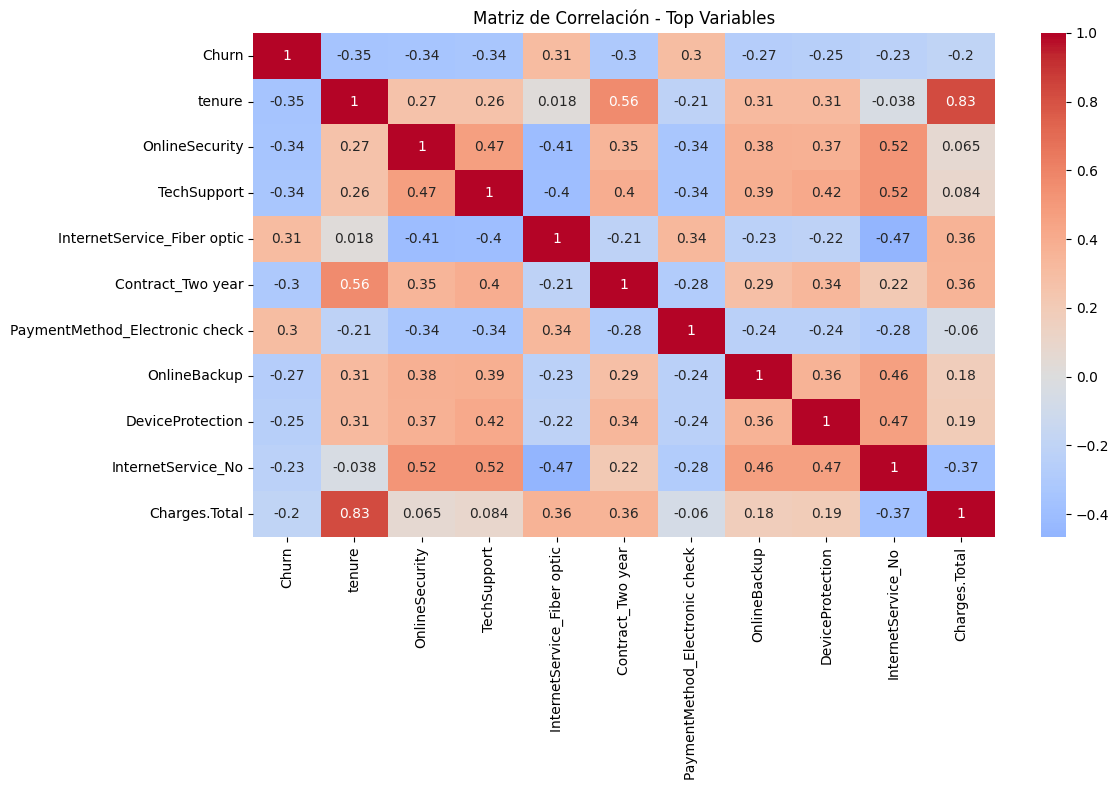

In [7]:
# Calcular correlación con la variable objetivo
correlaciones = df_encoded.corr()['Churn'].abs().sort_values(ascending=False)

# Mostrar las 15 variables más correlacionadas
print("Variables más correlacionadas con Churn:")
print(correlaciones.head(16))  # 16 porque incluye Churn consigo misma

# Visualizar matriz de correlación
plt.figure(figsize=(12, 8))
top_features = correlaciones.head(11).index  # Top 10 + Churn
corr_matrix = df_encoded[top_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación - Top Variables')
plt.tight_layout()
plt.show()

## Paso 2: Selección de características importantes

In [8]:
# Seleccionar variables con correlación > 0.1
umbral_correlacion = 0.1
variables_importantes = correlaciones[correlaciones > umbral_correlacion].index.tolist()
variables_importantes.remove('Churn')  # Remover la variable objetivo

print(f"Variables seleccionadas (correlación > {umbral_correlacion}):")
for var in variables_importantes:
    print(f"- {var}: {correlaciones[var]:.3f}")

print(f"\nTotal de variables seleccionadas: {len(variables_importantes)}")

# Actualizar datasets con variables seleccionadas
X_train_selected = X_train_balanced[variables_importantes]
X_test_selected = X_test[variables_importantes]

# También para datos escalados
scaler_selected = StandardScaler()
X_train_selected_scaled = scaler_selected.fit_transform(X_train_selected)
X_test_selected_scaled = scaler_selected.transform(X_test_selected)

print(f"Shape final de datos de entrenamiento: {X_train_selected.shape}")
print(f"Shape final de datos de prueba: {X_test_selected.shape}")

Variables seleccionadas (correlación > 0.1):
- tenure: 0.354
- OnlineSecurity: 0.342
- TechSupport: 0.337
- InternetService_Fiber optic: 0.307
- Contract_Two year: 0.302
- PaymentMethod_Electronic check: 0.301
- OnlineBackup: 0.268
- DeviceProtection: 0.252
- InternetService_No: 0.228
- Charges.Total: 0.199
- Cuentas_Diarias: 0.193
- Charges.Monthly: 0.193
- PaperlessBilling: 0.191
- Contract_One year: 0.178
- Dependents: 0.163
- SeniorCitizen: 0.151
- Partner: 0.150
- PaymentMethod_Credit card (automatic): 0.135
- StreamingMovies: 0.131
- StreamingTV: 0.128

Total de variables seleccionadas: 20
Shape final de datos de entrenamiento: (8260, 20)
Shape final de datos de prueba: (1407, 20)


# 3. Modelado Predictivo

## Paso 1: Entrenamiento de modelos

In [9]:
# Diccionario para almacenar modelos
modelos = {}

# 1. Regresión Logística (requiere normalización)
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_selected_scaled, y_train_balanced)
modelos['Logistic Regression'] = lr

# 2. KNN (requiere normalización)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_selected_scaled, y_train_balanced)
modelos['KNN'] = knn

# 3. Random Forest (no requiere normalización)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_selected, y_train_balanced)
modelos['Random Forest'] = rf

# 4. Decision Tree (no requiere normalización)
dt = DecisionTreeClassifier(random_state=42, max_depth=10)
dt.fit(X_train_selected, y_train_balanced)
modelos['Decision Tree'] = dt

print("Modelos entrenados:")
for nombre in modelos.keys():
    print(f"- {nombre}")

Modelos entrenados:
- Logistic Regression
- KNN
- Random Forest
- Decision Tree


## Paso 2: Evaluación de modelos

In [10]:
# Función para evaluar modelo
def evaluar_modelo(modelo, X_test_data, y_test, nombre):
    y_pred = modelo.predict(X_test_data)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    return {
        'Modelo': nombre,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

# Evaluar todos los modelos
resultados = []

# Modelos que requieren datos escalados
resultados.append(evaluar_modelo(modelos['Logistic Regression'], X_test_selected_scaled, y_test, 'Logistic Regression'))
resultados.append(evaluar_modelo(modelos['KNN'], X_test_selected_scaled, y_test, 'KNN'))

# Modelos que usan datos sin escalar
resultados.append(evaluar_modelo(modelos['Random Forest'], X_test_selected, y_test, 'Random Forest'))
resultados.append(evaluar_modelo(modelos['Decision Tree'], X_test_selected, y_test, 'Decision Tree'))

# Crear DataFrame con resultados
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.round(4)

print("Resultados de evaluación:")
print(df_resultados)

Resultados de evaluación:
                Modelo  Accuracy  Precision  Recall  F1-Score
0  Logistic Regression    0.7605     0.5401  0.6658    0.5964
1                  KNN    0.7363     0.5031  0.6578    0.5701
2        Random Forest    0.7719     0.5696  0.5802    0.5748
3        Decision Tree    0.7406     0.5095  0.6471    0.5701


## Paso 3: Selección del mejor modelo y análisis detallado

Mejor modelo: Logistic Regression
F1-Score: 0.5964


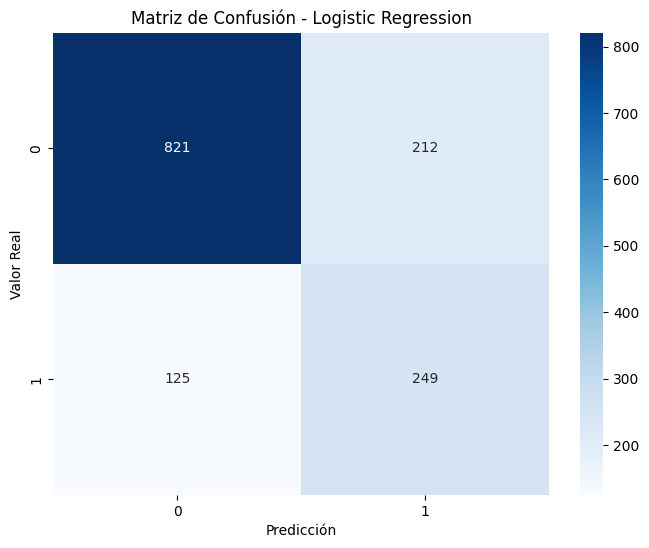


Reporte de clasificación - Logistic Regression:
              precision    recall  f1-score   support

       False       0.87      0.79      0.83      1033
        True       0.54      0.67      0.60       374

    accuracy                           0.76      1407
   macro avg       0.70      0.73      0.71      1407
weighted avg       0.78      0.76      0.77      1407



In [11]:
# Identificar el mejor modelo basado en F1-Score
mejor_modelo_idx = df_resultados['F1-Score'].idxmax()
mejor_modelo_nombre = df_resultados.loc[mejor_modelo_idx, 'Modelo']
mejor_modelo = modelos[mejor_modelo_nombre]

print(f"Mejor modelo: {mejor_modelo_nombre}")
print(f"F1-Score: {df_resultados.loc[mejor_modelo_idx, 'F1-Score']:.4f}")

# Predicciones del mejor modelo
if mejor_modelo_nombre in ['Logistic Regression', 'KNN']:
    y_pred_mejor = mejor_modelo.predict(X_test_selected_scaled)
else:
    y_pred_mejor = mejor_modelo.predict(X_test_selected)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_mejor)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confusión - {mejor_modelo_nombre}')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Reporte de clasificación
print(f"\nReporte de clasificación - {mejor_modelo_nombre}:")
print(classification_report(y_test, y_pred_mejor))

# 4. Interpretación y Conclusiones

## Paso 1: Análisis de importancia de variables

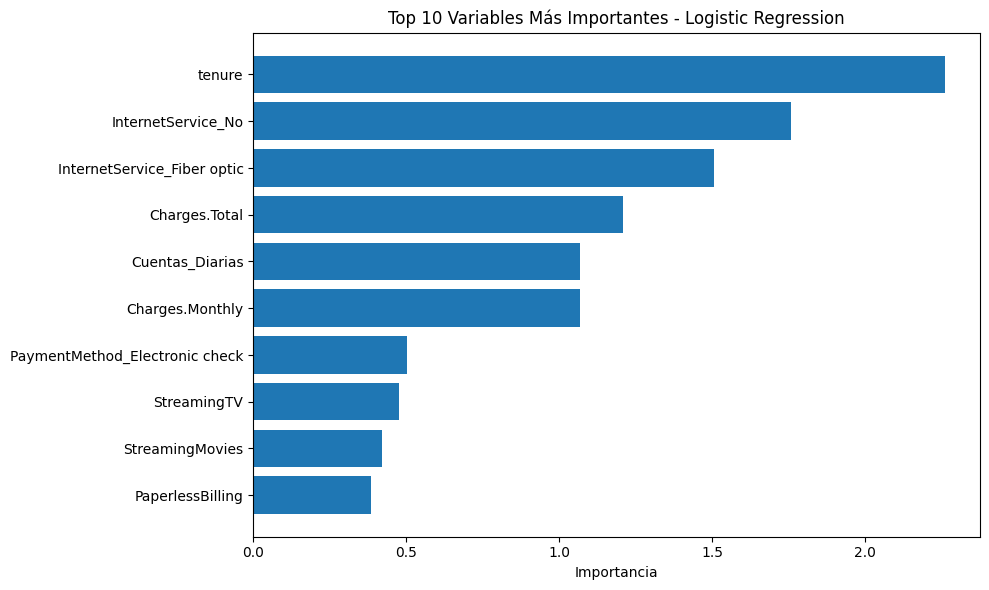

Top 10 variables más importantes:
tenure: 2.2613
InternetService_No: 1.7577
InternetService_Fiber optic: 1.5051
Charges.Total: 1.2087
Cuentas_Diarias: 1.0674
Charges.Monthly: 1.0674
PaymentMethod_Electronic check: 0.5022
StreamingTV: 0.4766
StreamingMovies: 0.4197
PaperlessBilling: 0.3833


In [12]:
# Análisis de importancia según el tipo de modelo
if mejor_modelo_nombre in ['Random Forest', 'Decision Tree']:
    # Para modelos de árbol, usar feature_importances_
    importancias = mejor_modelo.feature_importances_
    nombres_features = variables_importantes
    
elif mejor_modelo_nombre == 'Logistic Regression':
    # Para regresión logística, usar coeficientes absolutos
    importancias = np.abs(mejor_modelo.coef_[0])
    nombres_features = variables_importantes
    
else:  # KNN no tiene importancia de features directa
    print("KNN no proporciona importancia de features directamente.")
    print("Usando correlaciones como proxy de importancia:")
    importancias = [correlaciones[var] for var in variables_importantes]
    nombres_features = variables_importantes

# Crear DataFrame de importancias
df_importancias = pd.DataFrame({
    'Variable': nombres_features,
    'Importancia': importancias
}).sort_values('Importancia', ascending=False)

# Visualizar top 10 variables más importantes
plt.figure(figsize=(10, 6))
top_10 = df_importancias.head(10)
plt.barh(range(len(top_10)), top_10['Importancia'])
plt.yticks(range(len(top_10)), top_10['Variable'])
plt.xlabel('Importancia')
plt.title(f'Top 10 Variables Más Importantes - {mejor_modelo_nombre}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 10 variables más importantes:")
for i, row in top_10.iterrows():
    print(f"{row['Variable']}: {row['Importancia']:.4f}")

## Paso 2: Conclusiones y recomendaciones

In [16]:
# Resumen ejecutivo
print("ANÁLISIS DE CHURN:")

print(f"\n1. MODELO SELECCIONADO:")
print(f"   - Algoritmo: {mejor_modelo_nombre}")
print(f"   - Accuracy: {df_resultados.loc[mejor_modelo_idx, 'Accuracy']:.1%}")
print(f"   - Precision: {df_resultados.loc[mejor_modelo_idx, 'Precision']:.1%}")
print(f"   - Recall: {df_resultados.loc[mejor_modelo_idx, 'Recall']:.1%}")
print(f"   - F1-Score: {df_resultados.loc[mejor_modelo_idx, 'F1-Score']:.1%}")

print(f"\n2. VARIABLES MÁS INFLUYENTES:")
for i, row in df_importancias.head(5).iterrows():
    print(f"   - {row['Variable']}")

print(f"\n3. DISTRIBUCIÓN DE CHURN:")
churn_rate = (y_test.sum() / len(y_test)) * 100
print(f"   - Tasa de churn actual: {churn_rate:.1f}%")
print(f"   - Clientes en riesgo identificados: {y_pred_mejor.sum()} de {len(y_pred_mejor)}")

print(f"\n4. RECOMENDACIONES ESTRATÉGICAS:")
print(f"   - Implementar retención proactiva basada en las variables clave identificadas")
print(f"   - Monitorear continuamente los clientes de alto riesgo")
print(f"   - Desarrollar programas específicos para los factores más influyentes")
print(f"   - Actualizar el modelo mensualmente con nuevos datos")

ANÁLISIS DE CHURN:

1. MODELO SELECCIONADO:
   - Algoritmo: Logistic Regression
   - Accuracy: 76.0%
   - Precision: 54.0%
   - Recall: 66.6%
   - F1-Score: 59.6%

2. VARIABLES MÁS INFLUYENTES:
   - tenure
   - InternetService_No
   - InternetService_Fiber optic
   - Charges.Total
   - Cuentas_Diarias

3. DISTRIBUCIÓN DE CHURN:
   - Tasa de churn actual: 26.6%
   - Clientes en riesgo identificados: 461 de 1407

4. RECOMENDACIONES ESTRATÉGICAS:
   - Implementar retención proactiva basada en las variables clave identificadas
   - Monitorear continuamente los clientes de alto riesgo
   - Desarrollar programas específicos para los factores más influyentes
   - Actualizar el modelo mensualmente con nuevos datos
